# Introduction

- The training ENV is on window-10 and opencv 2.4.13
- This script is maining test the different ENV on Mac with opencv 3.1.x
- The process-flow are list below step by step.

# Import Modules 

In [1]:
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split


from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.models import model_from_json
#from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
np.random.seed(1337)  # for reproducibility

import os, sys, progressbar, argparse 
import commentjson as json

from imutils import paths
from skimage.io import imread
import imageio
import cv2

Using Theano backend.


# Data Clean Functions

In [2]:

class Conf:
    def __init__(self, confPath):
        # load and store the configuration and update the object's dictionary
        conf = json.loads(open(confPath).read())
        self.__dict__.update(conf)

    def __getitem__(self, k):
        # return the value associated with the supplied key
        return self.__dict__.get(k, None)
    
    
def auto_resized(img,size):
    '''size = (width,height)'''
    size = tuple(size)
    resize_img = cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)
    return resize_img


def TrainFilePath(folderPath, constrain=None, **kargs):
    '''
    (1) Output filepath and calssName
    (2) folderPath 
          --label_1
           -- xxx.jpg
    '''
    assert folderPath[-1]!='/'
    if constrain is None:
        constrain = ('avi', 'mp4','png','jpg') 
    for (rootDir, dirNames, fileNames) in os.walk(folderPath):
        for fileName in fileNames:
            if fileName.split('.')[-1] in constrain:
                yield (os.path.join(rootDir, fileName)) 

#img_channels = 3
def genTrX(filePath, resolution, img_channels=3):
    assert type(resolution) == tuple
    img = auto_resized(imread(filePath),resolution)  #conf['sliding_size']
    if img_channels==1:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif img_channels==3:
        img = img[:,:,:3]
    return img

def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in xrange(0, image.shape[0], stepSize):
        for x in xrange(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def load_training(folderList):
    TrY = []
    TrX = []
    TrY_template = np.eye(len(folderList))
    for eyeId, folderPath in enumerate(folderList):
        for imgPath in TrainFilePath(folderPath) :
            TrY.append(TrY_template[eyeId])
            TrX.append(genTrX(imgPath, (img_rows,img_cols), img_channels))
    print (len(TrX))
    return TrX, TrY

def reshapeShuffle(TrX, TrY, img_rows, img_cols, img_channels):
    trainX = np.asarray(TrX, dtype = np.uint8)
    trainX = trainX.reshape(trainX.shape[0], img_channels, img_rows, img_cols)
    trainX = trainX.astype('float32')
    trainY = np.asarray(TrY, dtype = np.float32)
    # shuffle
    trainX , trainY = shuffle(trainX,trainY)
    print ('Train_X : ',trainX.shape,'Train_Y' ,trainY.shape)
    return trainX , trainY

# Setting and pre-process the data in consistence

In [3]:
if os.name=='nt':
    foler_list = ['D:\\2D_DataSet\\PureScrewDriver', 'D:\\2D_DataSet\\Rhand_v2']
else:
    foler_list = ['/Users/kentchiu/MIT_Vedio/2D_DataSet/PureScrewDriver', '/Users/kentchiu/MIT_Vedio/2D_DataSet/Rhand_v2']

img_rows = 30
img_cols = 30
img_channels = 1
nb_classes = len(foler_list)

batch_size = 1

# EPOCH SENEITIVE ...
nb_epoch = 25

# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 2
# convolution kernel size
nb_conv = 3

##############
# Clean Data # 
##############
#model = simpleCNN(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols, img_channels)
#model = simpleCNN_3(nb_classes, nb_filters,nb_conv,nb_pool,img_rows,img_cols, img_channels)
TrX, TrY = load_training(foler_list)
trainX , trainY = reshapeShuffle(TrX, TrY, img_rows, img_cols, img_channels=img_channels)

151
('Train_X : ', (151, 1, 30, 30), 'Train_Y', (151, 2))


# Not training mode, use simple train_test_split

In [4]:
Tr_X, Te_X, Tr_Y, Te_Y = train_test_split(trainX, trainY, test_size=0.4, random_state=0)
print ("Training and testing split was successful.")

Training and testing split was successful.


# Loading Model with same setting 

In [5]:

json_file = open('../hub/model/model.json0907_2', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# This should be the same as training 
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
loaded_model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])
print ('Successful loading Model')

loaded_model.load_weights('../hub/model/0907_2.h5')
print ('Successful loading Model Weight')

Successful loading Model
Successful loading Model Weight


# Model Evaluations 

In [6]:
score = loaded_model.evaluate(Te_X, Te_Y, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])
print(loaded_model.summary())

('Test score:', 0.00076949526555836201)
('Test accuracy:', 1.0)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_15 (Convolution2D) (None, 32, 28, 28)    320         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_32 (Activation)       (None, 32, 28, 28)    0           convolution2d_15[0][0]           
____________________________________________________________________________________________________
convolution2d_16 (Convolution2D) (None, 32, 26, 26)    9248        activation_32[0][0]              
____________________________________________________________________________________________________
activation_33 (Activation)       (None, 32, 26, 26)    0           convolution2d_16[0][0]           
___________________________

# Further Visualizations

(30L, 30L)
(1L, 1L, 30L, 30L)
1/1 [==============================] - 0s
[[  1.00000000e+00   5.58050217e-10]]


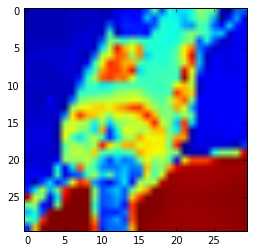

In [7]:

from ipywidgets import interact, interactive, fixed
from ipywidgets import widgets

def f(x):
    
    #plt.imshow(Tr_X[x].reshape(img_rows,img_rows,3)) # color
    plt.imshow(TrX[x].reshape(img_rows,img_rows)) # gray
    print TrX[x].shape
    print (TrX[x].reshape(1,img_channels,img_rows,img_rows)).shape
    print (loaded_model.predict_proba(TrX[x].reshape(1,img_channels,img_rows,img_rows)) )
    #print (loaded_model.predict_classes(TrX[x].reshape(1,img_channels,img_rows,img_rows)) ,'--><--', np.argmax(TrY[x]) )

interact(f,x = 20)

# Further Detection Testing

## Explanation

- We load the Vid from Data_hub first. 
- Then we use **Memo** class to storage the potential box and prob.
- Finally we use **detection_test** test the model performance from Keras use predict_proba()


In [6]:
import imageio
from skimage.io import imread, imshow
import imutils

In [7]:
if os.name=='nt':
    
    vid = imageio.get_reader('D:\\2016-01-21\\10.167.10.158_01_20160121082638418_1.mp4')
else:
    vid = imageio.get_reader('/Users/kentchiu/MIT_Vedio/2016-01-21/10.167.10.158_01_20160121082638418_1.mp4')


/Users/kentchiu/Library/Application Support/imageio/ffmpeg/ffmpeg.osx
/Users/kentchiu/anaconda/lib/python2.7/site-packages/imageio/resources/ffmpeg/ffmpeg.osx


In [48]:
import common_func
import gc
# http://stackoverflow.com/questions/22440421/python-is-the-garbage-collector-run-before-a-memoryerror-is-raised
# if there are hidden reference cycles 
# use gc.collect() to manually release the memory in each iteration


def singleton(class_):
  instances = {}
  def getinstance(*args, **kwargs):
    if class_ not in instances:
        instances[class_] = class_(*args, **kwargs)
    return instances[class_]
  return getinstance

@singleton
class Memo(object):
    def __init__(self, numLabel):
        self.boxes={}
        self.prob ={}
        for i in range(numLabel):
            self.boxes[i]=[]
            self.prob[i]=[]
            
    def addNode(self, labelID, box, prob):
        assert type(box)==tuple
        self.boxes[labelID].append(box)
        self.prob[labelID].append(prob)
    
    def extratResult(self,labelID):
        try :
            return self.boxes[labelID], self.prob[labelID]
        except Exception as err:
            print (err)

# windim = (x,y) = 32, 32 this case
def detection_test(x, model, winDim, pyramidScale=20,winStep=20, minProb=0.9995, numLabel=2):
    '''
    numLable = y-label number 
    in this case, we have 2 lebels 0 and 1
    '''
    assert type(x)==int
    assert x>=0
    image = vid.get_data(x)
    image = imutils.resize(image, width=200)
    
    memo = Memo(numLabel)
    
    orig = image.copy()
    img_gray = cv2.cvtColor( image , cv2.COLOR_BGR2GRAY)
    # loop over the image pyramid
    for layer in common_func.pyramid(img_gray, scale=pyramidScale, minSize=winDim):
        # determine the current scale of the pyramid
        scale = image.shape[0] / float(layer.shape[0])

        # loop over the sliding windows for the current pyramid layer
        for (x, y, window) in common_func.sliding_window(layer, winStep, winDim):
            # grab the dimensions of the window
            (winH, winW) = window.shape[:2]
            

            # ensure the window dimensions match the supplied sliding window dimensions
            if winH == winDim[1] and winW == winDim[0]:
                window = window.reshape(1,1,winW,winH)

                #return window [0][0]
                probS = model.predict_proba(window,verbose=0)[0]

                # check to see if the classifier has found an object with sufficient
                # probability
                    
                for label, prob in enumerate(probS):
                    if prob>minProb:
                        (startX, startY) = (int(scale * x), int(scale * y))
                        endX = int(startX+(scale * winW))
                        endY = int(startY+(scale * winH))
                        #
                        box = (startX, startY, endX, endY)
                        memo.addNode(label, box, prob)
    print ('END Detect')
    for label in range(numLabel):
        boxes, probs = memo.extratResult(label)
        pick = common_func.non_max_suppression(np.array(boxes), probs, 0.7)
        # loop over the allowed bounding boxes and draw them
        for (startX, startY, endX, endY) in pick:
            if startY < 10 or startX < 10 or abs(startX - endX)>50 or abs(startX - endX)<15 :
                pass
            else: 
                cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, label*255), 2)
    return orig





In [53]:

img = detection_test(1500, model=loaded_model,winDim=(30,30))


END Detect


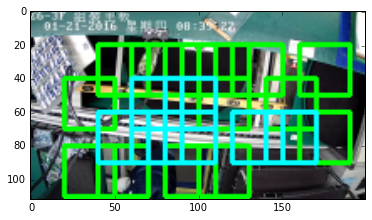

In [54]:
plt.imshow(img) # gray

# Reference Code

In [43]:
# storageMemo
class Node:
    def __init__(self,boxes, prob):
        self.boxes = boxes
        self.prob = prob
        
        
class Memo(Node):
    def __init__(self, labelnumber):
        self.boxes={}
        self.prob ={}
        for i in range(labelnumber):
            self.boxes[i]=[]
            self.prob[i]=[]
            
    def addNode(self, labelID, box, prob):
        assert type(box)==tuple
        self.boxes[labelID].append(box)
        self.prob[labelID].append(prob)
    
    def extratResult(self,labelID):
        try :
            return self.boxes[labelID], self.prob[labelID]
        except Exception as err:
            print (err)
        


a= Memo(4)
a.addNode(0,(2,4,5,6),0.78)
a.addNode(1,(12,14,15,16),0.78)
a.addNode(2,(22,24,25,26),0.78)
a.addNode(2,(22,24,25,26),0.78)
a.addNode(3,(32,34,35,36),0.78)

for i in range(5):
    print a.extratResult(i)

([(2, 4, 5, 6)], [0.78])
([(12, 14, 15, 16)], [0.78])
([(22, 24, 25, 26), (22, 24, 25, 26)], [0.78, 0.78])
([(32, 34, 35, 36)], [0.78])
4
None


In [31]:
class Node:
    def __init__(self,data):
        self.left = None
        self.right = None
        self.data = data

class BinaryTree:

    def __init__(self):
        self.root = None


    def insert_node(self,root,element):
        if self.root is None:
            self.root = Node(element)
        else:

            if root is None:
                root = Node(element)
            elif root.data <= element:
                root.right = self.insert_node(root.right,element)
            elif root.data > element:
                root.left = self.insert_node(root.left,element)


        return root

    def PreOrder(self,root):
        if root is not None:
            print(root.data)
            if root.left is not None:
                self.PreOrder(root.left)
            if root.right is not None:
                self.PreOrder(root.right)



a = BinaryTree()
a.insert_node(a.root,3)
a.insert_node(a.root,4)
a.insert_node(a.root,34)
a.insert_node(a.root,45)
a.insert_node(a.root,46)
a.insert_node(a.root,2)
a.insert_node(a.root,48)
a.PreOrder(a.root)

3
2
4
34
45
46
48


In [29]:
a = [[1,1,1,4,5],[[3343]*5],[(4,5)*5]]
a = np.array(a)

a
#a[1]

array([[1, 1, 1, 4, 5], [[3343, 3343, 3343, 3343, 3343]],
       [(4, 5, 4, 5, 4, 5, 4, 5, 4, 5)]], dtype=object)

In [12]:
class ObjectDetector:
    def __init__(self, model, desc):
        # store the classifier and HOG descriptor
        self.model = model
        self.desc = desc

    def detect(self, image, winDim, winStep=4, pyramidScale=1.5, minProb=0.7):
        # initialize the list of bounding boxes and associated probabilities
        memo = {}
        boxes = []
        probs = []

        # loop over the image pyramid
        for layer in common_func.pyramid(image, scale=pyramidScale, minSize=winDim):
            # determine the current scale of the pyramid
            scale = image.shape[0] / float(layer.shape[0])

            # loop over the sliding windows for the current pyramid layer
            for (x, y, window) in common_func.sliding_window(layer, winStep, winDim):

                # grab the dimensions of the window
                (winH, winW) = window.shape[:2]

                # ensure the window dimensions match the supplied sliding window dimensions
                if winH == winDim[1] and winW == winDim[0]:
                    # extract HOG features from the current window and classifiy whether or
                    # not this window contains an object we are interested in
                    features = self.desc.describe(window)
                    features.reshape(-1, 1) # due to the depreciation
                    probS = self.model.predict_proba(features)[0]

                    # check to see if the classifier has found an object with sufficient
                    # probability
                    if prob > minProb:
                        # compute the (x, y)-coordinates of the bounding box using the current
                        # scale of the image pyramid
                        (startX, startY) = (int(scale * x), int(scale * y))
                        endX = int(startX + (scale * winW))
                        endY = int(startY + (scale * winH))

                        # update the list of bounding boxes and probabilities
                        boxes.append((startX, startY, endX, endY))
                        probs.append(prob)

        # return a tuple of the bounding boxes and probabilities
        return (boxes, probs)


class MultiObjectDetection(ObjectDetector):
    def __init__(self,labNums,model, desc):
        ObjectDetector.__init__(self, model, desc)
        self.labNums = labNums

    def detect(self, image, winDim, winStep=4, pyramidScale=1.5, minProb=0.7):
        # initialize the list of bounding boxes and associated probabilities
        labels = []
        boxes = []
        probs = []

        # loop over the image pyramid
        for layer in common_func.pyramid(image, scale=pyramidScale, minSize=winDim):
            # determine the current scale of the pyramid
            scale = image.shape[0] / float(layer.shape[0])

            # loop over the sliding windows for the current pyramid layer
            for (x, y, window) in common_func.sliding_window(layer, winStep, winDim):

                # grab the dimensions of the window
                (winH, winW) = window.shape[:2]

                # ensure the window dimensions match the supplied sliding window dimensions
                if winH == winDim[1] and winW == winDim[0]:
                    # extract HOG features from the current window and classifiy whether or
                    # not this window contains an object we are interested in
                    features = self.desc.describe(window)
                    features.reshape(-1, 1) # due to the depreciation
                    probS = self.model.predict_proba(features)[0][1]

                    ##################
                    # softmax return multiple probability value
                    for label, prob in enumerate(probS):
                        if prob>minProb:
                            (startX, startY) = (int(scale * x), int(scale * y))
                            endX = int(startX+(scale * winW))
                            endY = int(startY+(scale * winH))
                            #
                            labels.append(label)
                            boxes.append((startX, startY, endX, endY))
                            probs.append(prob)

        return np.array([labels, boxes, probs])